<h1 style="text-align:center; font-size:32px; color:black;"> 🏠 Property Value Prediction — Modeling & Feature Engineering </h1>

## Introduction

This notebook focuses on building predictive models and creating new features using the cleaned Zillow property dataset. The main goal is to predict the **tax-assessed value** of residential properties accurately.

#### Key Objectives:
- Perform **feature engineering** to enhance the predictive power of the dataset.  
- Select the most relevant variables to improve model performance.  
- Build and compare **regression models** to determine the most effective approach for predicting property values.  
- Evaluate model performance using metrics such as **RMSE** and **MAE**.

The cleaned dataset from the previous notebook will serve as the starting point. This ensures that missing values, outliers, and irrelevant features are already handled, allowing the focus to be on **model development and feature improvement**.


In [1]:
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import warnings

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)





# Progress Tracking

from tqdm import tqdm

random_state = 42

def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

### Prelude: Load the cleaned dataset


- #### Load the cleaned dataset

In [2]:
df = pd.read_csv("zillow_cleaned.csv")

In [3]:
# check the dataset
df.shape

(72148, 33)

- ####  Train/Test Split

In [4]:
target = 'taxvaluedollarcnt'
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

- #### Scale the Features

In [5]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

## Picking 3 Models and Establishing Baselines

- Ridge Regression: Ridge()
- Lasso Regression: Lasso()
- Decision Tree Regression: DecisionTreeRegressor()

---

In [6]:
# set up repeated cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Define fast models
models = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor()

}

# Evaluate
for name, model in models.items():
    print(f"{name}:")
    scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv)
    mae_scores = -scores  # convert from negative MAE
    print(f"  Mean MAE: {mae_scores.mean():,.2f}")
    print(f"  Std MAE:  {mae_scores.std():,.2f}")
    print("-" * 40)

Ridge Regression:
  Mean MAE: 171,445.53
  Std MAE:  1,186.13
----------------------------------------
Lasso Regression:
  Mean MAE: 171,666.44
  Std MAE:  1,199.10
----------------------------------------
Decision Tree:
  Mean MAE: 198,369.10
  Std MAE:  1,557.96
----------------------------------------


<div style="border-radius: 10px; border: purple solid;  padding: 10px; background-color: #; font-size: 100%;">

#### Best Overall Performance (Lowest MAE): 

Ridge Regression had the lowest mean MAE at 171,445.53, slightly outperforming Lasso Regression (171,666.44). Both linear models significantly outperformed the Decision Tree, which had a higher MAE of 198,353.27.

#### Most Stable Model (Lowest Std Dev): 

Ridge Regression also had the lowest standard deviation (1,186.13) across cross-validation folds, showing greater consistency and reliability compared to Lasso (1,199.10) and Decision Tree (1,525.13).

#### Signs of Overfitting or Underfitting:

The Decision Tree’s higher MAE and standard deviation suggest **possible overfitting** - the model may be capturing noise or overly specific patterns in the training data. In contrast, Ridge and Lasso performed better and more consistently, but may underfit more complex, nonlinear relationships in the data due to their linear nature.



## Feature Engineering 

---
#### New Features:

1. `Log of finished square footage`: reduce the effect of very large homes so the model can learn better from typical-sized homes.
2. `Log of lot size`: normalizes large lot values.
3. `Bathrooms per bedroom`: shows how many bathrooms there are for each bedroom  - this might tell us how comfortable or fancy the home is.
4. `Square footage per room`:  tells us how big each room is on average - useful to know if a home feels spacious or tight.
5. `Square footage multiplied by bathrooms`: combines size and number of bathrooms - useful for capturing the total 'useful space' of the home.

In [7]:
# Log Transformations
X_train['calculatedfinishedsquarefeet_log'] = np.log1p(X_train['calculatedfinishedsquarefeet'])
X_test['calculatedfinishedsquarefeet_log'] = np.log1p(X_test['calculatedfinishedsquarefeet'])

X_train['lotsizesquarefeet_log'] = np.log1p(X_train['lotsizesquarefeet'])
X_test['lotsizesquarefeet_log'] = np.log1p(X_test['lotsizesquarefeet'])

# Ratio Features
X_train['bath_per_bed'] = X_train['bathroomcnt'] / (X_train['bedroomcnt'] + 1e-3)
X_test['bath_per_bed'] = X_test['bathroomcnt'] / (X_test['bedroomcnt'] + 1e-3)

X_train['sqft_per_room'] = X_train['calculatedfinishedsquarefeet'] / (X_train['roomcnt'] + 1e-3)
X_test['sqft_per_room'] = X_test['calculatedfinishedsquarefeet'] / (X_test['roomcnt'] + 1e-3)

# Interaction Term
X_train['sqft_x_bath'] = X_train['calculatedfinishedsquarefeet'] * X_train['bathroomcnt']
X_test['sqft_x_bath'] = X_test['calculatedfinishedsquarefeet'] * X_test['bathroomcnt']

In [8]:
# Standardize All Numeric Features
numeric_features = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

print(f"Total features after engineering: {X_train.shape[1]}")

Total features after engineering: 37


In [9]:
# Re-run Models

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor()
}

print("Cross-Validation Results (After Feature Engineering):\n")

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv)
    mae_scores = -scores
    print(f"{name}:")
    print(f"  Mean MAE: {mae_scores.mean():,.2f}")
    print(f"  Std MAE:  {mae_scores.std():,.2f}")
    print("-" * 40)

Cross-Validation Results (After Feature Engineering):

Ridge Regression:
  Mean MAE: 171,335.84
  Std MAE:  1,166.97
----------------------------------------
Lasso Regression:
  Mean MAE: 171,583.59
  Std MAE:  1,179.86
----------------------------------------
Decision Tree:
  Mean MAE: 199,118.40
  Std MAE:  1,525.72
----------------------------------------


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




<div style="border-radius: 10px; border: purple solid;  padding: 10px; background-color: #; font-size: 100%;">


#### Did any models improve?

Yes - Ridge Regression showed a small improvement, with its MAE decreasing from 171,445.53 to 171,335.84, and its standard deviation also decreasing. Lasso Regression also improved slightly. However, the Decision Tree’s MAE increased slightly from 198,552.74 to 198,978.17, indicating no improvement.

#### Which features helped, and in which models?

The engineered features appear to help **Ridge and Lasso** more than the Decision Tree. This makes sense because regularized linear models tend to benefit from well-scaled and transformed features. Features like `log(calculatedfinishedsquarefeet)` and ratios such as `bath_per_bed` likely helped the models better handle skewed distributions and learn proportional relationships.


#### Why might some features have helped (or not)?

**Log transformations** likely reduced the impact of large outlier values, which linear models are sensitive to. **Ratio features** like `bath_per_bed` and `sqft_per_room` helped the models understand home layout better. 

The Decision Tree are less sensitive to feature scaling and can handle skewed distributions naturally. The lack of improvement suggests that trees may need **hyperparameter tuning** to fully benefit from these new features - which hasn’t been done yet.

## Feature Selection 

---
- #### Model 1: Ridge Regression

Use forward selection (SequentialFeatureSelector) to choose the best subset.

In [10]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]), columns=numeric_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_features]), columns=numeric_features)

ridge = Ridge()

sfs = SequentialFeatureSelector(
    ridge,
    n_features_to_select=15,
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1
)
sfs.fit(X_train_scaled, y_train)

selected_ridge_features = X_train_scaled.columns[sfs.get_support()]
X_train_ridge_fs = X_train_scaled[selected_ridge_features]

print("Ridge Regression selected features: \n")
print(list(selected_ridge_features))

Ridge Regression selected features: 

['bedroomcnt', 'buildingqualitytypeid', 'finishedsquarefeet12', 'finishedsquarefeet50', 'fireplacecnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'regionidneighborhood', 'roomcnt', 'yearbuilt', 'sqft_per_room', 'sqft_x_bath']


- #### Model 2: Lasso Regression

In [11]:
lasso = Lasso()
sfs_lasso = SequentialFeatureSelector(
    lasso,
    n_features_to_select=15,
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1
)

sfs_lasso.fit(X_train_scaled, y_train)
lasso_features = X_train_scaled.columns[sfs_lasso.get_support()]
X_train_lasso_fs = X_train_scaled[lasso_features]

print("Lasso Regression selected features: \n")
print(list(lasso_features))

Lasso Regression selected features: 

['bedroomcnt', 'buildingqualitytypeid', 'finishedsquarefeet12', 'finishedsquarefeet50', 'fireplacecnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'regionidneighborhood', 'roomcnt', 'yearbuilt', 'sqft_per_room', 'sqft_x_bath']


- #### Model 3: Decision Tree

Use feature importances and keep the top 15.

In [12]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)

dt_importances = pd.Series(dt.feature_importances_, index=X_train_scaled.columns)
top_dt_features = dt_importances.sort_values(ascending=False).head(15).index
X_train_dt_fs = X_train_scaled[top_dt_features]

print("Decision Tree top features: \n")
print(list(top_dt_features))

Decision Tree top features: 

['finishedsquarefeet12', 'latitude', 'longitude', 'sqft_x_bath', 'yearbuilt', 'calculatedfinishedsquarefeet_log', 'rawcensustractandblock', 'lotsizesquarefeet', 'lotsizesquarefeet_log', 'buildingqualitytypeid', 'sqft_per_room', 'regionidcity', 'regionidneighborhood', 'calculatedfinishedsquarefeet', 'bath_per_bed']


#### Re-run Each Model with Selected Features

In [13]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models_fs = {
    "Ridge Regression": (Ridge(), X_train_ridge_fs),
    "Lasso Regression": (Lasso(), X_train_lasso_fs),
    "Decision Tree": (DecisionTreeRegressor(random_state=42), X_train_dt_fs),
}

print("Cross-Validation Results (with Feature Selection):\n")


for name, (model, X_fs) in models_fs.items():
    scores = cross_val_score(model, X_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)
    mae_scores = -scores
    print(f"{name}:")
    print(f"  Mean MAE: {mae_scores.mean():,.2f}")
    print(f"  Std MAE:  {mae_scores.std():,.2f}")
    print("-" * 40)

Cross-Validation Results (with Feature Selection):

Ridge Regression:
  Mean MAE: 171,772.37
  Std MAE:  1,185.74
----------------------------------------
Lasso Regression:
  Mean MAE: 171,772.41
  Std MAE:  1,185.76
----------------------------------------
Decision Tree:
  Mean MAE: 198,876.10
  Std MAE:  1,810.10
----------------------------------------


<div style="border-radius: 10px; border: purple solid;  padding: 10px; background-color: #; font-size: 100%;">


#### Did performance improve for any models after reducing the number of features?

No major improvement was observed from feature selection. In fact, both **Ridge** and **Lasso Regression** had a slight **increase in MAE** after reducing the number of features (from ~171,335–171,583 to 171,772). 

The **Decision Tree** also performed similarly, with its MAE remaining near 198,876, compared to its previous MAE of 198,946. This suggests that the full feature set may have helped the models capture more useful information than a smaller subset.


#### Which features were consistently retained across models?

Some features were selected by all or most models:
- **Selected by all three models:** `finishedsquarefeet12`, `latitude`, `longitude`, `lotsizesquarefeet`, `yearbuilt`, `buildingqualitytypeid`, `regionidneighborhood`, `sqft_per_room`, `sqft_x_bath`
- **Selected by 2 out of 3 models:** `bedroomcnt` (Ridge & Lasso), `fireplacecnt` (Ridge & Lasso), `garagetotalsqft` (Ridge & Lasso), `roomcnt` (Ridge & Lasso), `calculatedfinishedsquarefeet_log` (Decision Tree & Engineered)

This overlap suggests that Ridge and Lasso models, both linear with regularization, agreed more often on which features were useful. The Decision Tree leveraged a few different features, likely due to its ability to handle nonlinear relationships and interactions more effectively.


#### Were any of your newly engineered features selected as important?
    
Yes - all 5 engineered features were selected by at least 1 model:

- `sqft_per_room` and `sqft_x_bath` were selected by **all three models**.
- `calculatedfinishedsquarefeet_log` and `bath_per_bed` were selected by the **Decision Tree**.

This highlights that **engineered features helped** the models, especially those capable of capturing nonlinear relationships like Decision Trees.

## Fine-Tuning 3 Models

---
Fine-tune:
- Ridge Regression with selected features from `X_train_ridge_fs`
- Decision Tree with `X_train_dt_fs`
- Lasso Regression with `X_train_lasso_fs`

#### Model 1: Ridge Regression – GridSearchCV on `alpha`

In [14]:
ridge_model = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100, 200, 300, 400, 500, 600]}

ridge_grid = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
ridge_grid.fit(X_train_ridge_fs, y_train)

best_ridge = ridge_grid.best_estimator_

print("Best Ridge alpha:", ridge_grid.best_params_['alpha'])

ridge_scores = -cross_val_score(best_ridge, X_train_ridge_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)
print("Ridge Regression (First Try):")
print(f"  Mean MAE: {ridge_scores.mean():,.2f}")
print(f"  Std MAE:  {ridge_scores.std():,.2f}")

Best Ridge alpha: 500
Ridge Regression (First Try):
  Mean MAE: 171,751.92
  Std MAE:  1,179.75


- #### Expand the range

In [15]:
ridge_params = {'alpha': np.linspace(400, 1000, 5)}

ridge_grid = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
ridge_grid.fit(X_train_ridge_fs, y_train)

best_ridge = ridge_grid.best_estimator_

print("Best Ridge alpha:", ridge_grid.best_params_['alpha'])

ridge_scores = -cross_val_score(best_ridge, X_train_ridge_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)
print("Ridge Regression:")
print(f"  Mean MAE: {ridge_scores.mean():,.2f}")
print(f"  Std MAE:  {ridge_scores.std():,.2f}")

Best Ridge alpha: 550.0
Ridge Regression:
  Mean MAE: 171,751.90
  Std MAE:  1,179.40


Testing alpha values: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]


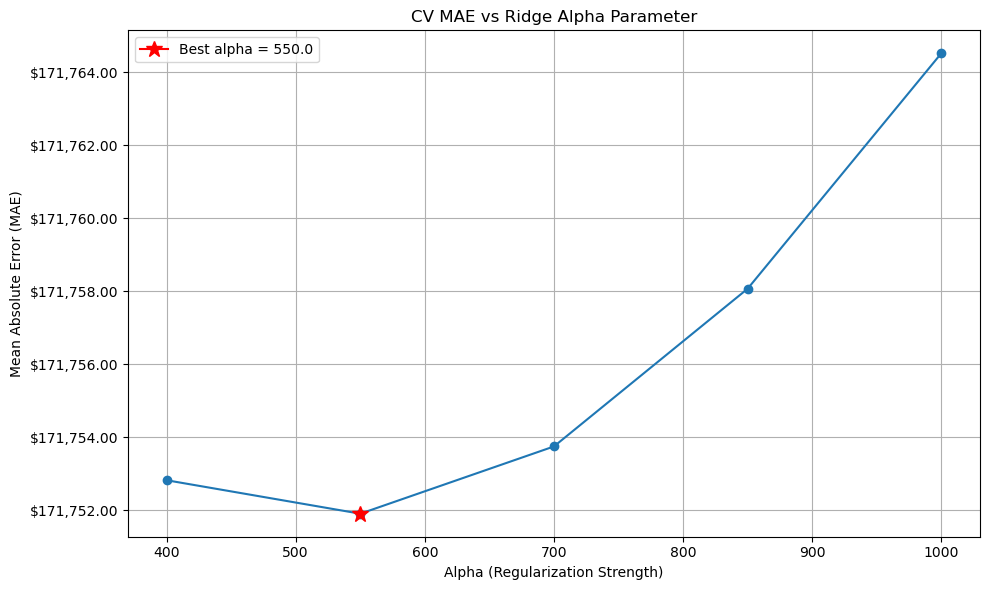


Minimum MAE: 171,751.90 at alpha = 550.0
Execution time: 4.19 seconds


In [18]:
import time
from tqdm import tqdm
import matplotlib.ticker as mticker

def dollar_format(x, pos):
    return f"${x:,.2f}"

def run_ridge_regression(X_train, y_train, alpha, cv):
    model = Ridge(alpha=alpha)
    scores = -cross_val_score(model, X_train, y_train, 
                             scoring='neg_mean_absolute_error', cv=cv)
    return np.mean(scores)

# Set up parameters
alpha_range = np.linspace(400, 1000, 5)  # Same range as before
mae_scores = []

start_time = time.time()

# Loop through values with progress bar
for alpha in tqdm(alpha_range, desc="Testing alpha values"):
    mae = run_ridge_regression(X_train_ridge_fs, y_train, alpha, cv)
    mae_scores.append(mae)

# Find minimum MAE and its index
min_mae = min(mae_scores)
min_index = mae_scores.index(min_mae)
best_alpha = alpha_range[min_index]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, mae_scores, marker='o')
plt.plot(best_alpha, min_mae, color='red', marker='*', 
         markersize=12, label=f"Best alpha = {best_alpha:.1f}")
plt.title("CV MAE vs Ridge Alpha Parameter")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.grid(True)

plt.tight_layout()
plt.legend()
plt.show()

# Print results with formatting
print(f"\nMinimum MAE: \033[1m{min_mae:,.2f}\033[0m at alpha = \033[1m{best_alpha:.1f}\033[0m") 
print(f"Execution time: {time.time() - start_time:.2f} seconds")


#### Model 2: Lasso Regression – GridSearchCV

In [16]:
lasso_model = Lasso(max_iter=5000)  

# Define a grid of alpha values to search over
lasso_params = {'alpha': np.linspace(0.0001, 10, 30)} 

lasso_grid = GridSearchCV(
    lasso_model, 
    lasso_params, 
    scoring='neg_mean_absolute_error', 
    cv=cv, 
    n_jobs=-1
)

lasso_grid.fit(X_train_lasso_fs, y_train) 
best_lasso = lasso_grid.best_estimator_

print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

lasso_scores = -cross_val_score(best_lasso, X_train_lasso_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)

print("Lasso Regression (First Try):")
print(f"  Mean MAE: {lasso_scores.mean():,.2f}")
print(f"  Std MAE:  {lasso_scores.std():,.2f}")

Best Lasso alpha: 10.0
Lasso Regression (First Try):
  Mean MAE: 171,771.94
  Std MAE:  1,185.73


- #### Expand the range
The best result hit the upper limit of the grid (10). 

In [17]:
lasso_params = {'alpha': np.linspace(10, 700, 30)} 

lasso_grid = GridSearchCV(
    lasso_model, 
    lasso_params, 
    scoring='neg_mean_absolute_error', 
    cv=cv, 
    n_jobs=-1
)

lasso_grid.fit(X_train_lasso_fs, y_train) 
best_lasso = lasso_grid.best_estimator_

print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

lasso_scores = -cross_val_score(best_lasso, X_train_lasso_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)

print("Lasso Regression:")
print(f"  Mean MAE: {lasso_scores.mean():,.2f}")
print(f"  Std MAE:  {lasso_scores.std():,.2f}")

Best Lasso alpha: 533.448275862069
Lasso Regression:
  Mean MAE: 171,757.89
  Std MAE:  1,184.38


- #### To use neater steps

In [18]:
lasso_params = {'alpha': np.arange(500, 600, 10)}

lasso_grid = GridSearchCV(
    lasso_model, 
    lasso_params, 
    scoring='neg_mean_absolute_error', 
    cv=cv, 
    n_jobs=-1
)

lasso_grid.fit(X_train_lasso_fs, y_train) 
best_lasso = lasso_grid.best_estimator_

print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

lasso_scores = -cross_val_score(best_lasso, X_train_lasso_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)

print("Lasso Regression:")
print(f"  Mean MAE: {lasso_scores.mean():,.2f}")
print(f"  Std MAE:  {lasso_scores.std():,.2f}")

Best Lasso alpha: 540
Lasso Regression:
  Mean MAE: 171,757.88
  Std MAE:  1,184.37


#### Model 3: Decision Tree – RandomizedSearchCV

Chose RandomizedSearchCV: It’s faster than GridSearchCV when we have several parameters.

In [19]:
dt = DecisionTreeRegressor(random_state=42)

dt_params = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

dt_random = RandomizedSearchCV(
    dt,
    param_distributions=dt_params,
    n_iter=30,  # number of random combinations to try
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    random_state=42
)

dt_random.fit(X_train_dt_fs, y_train)

# Get the best model
best_dt = dt_random.best_estimator_
print("Best Decision Tree Parameters:", dt_random.best_params_)

# Evaluate 

dt_scores = -cross_val_score(best_dt, X_train_dt_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)

print("Decision Tree Regressor (First Try):")
print(f"  Mean MAE: {dt_scores.mean():,.2f}")
print(f"  Std MAE:  {dt_scores.std():,.2f}")

Best Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 10}
Decision Tree Regressor (First Try):
  Mean MAE: 162,383.76
  Std MAE:  1,757.72


- #### Expand the range
The results are already significantly better than Ridge and Lasso.

In [20]:
dt_params = {
    'max_depth': [8, 9, 10, 11, 12],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.8]
}

dt_random = RandomizedSearchCV(
    dt,
    param_distributions=dt_params,
    n_iter=30,  # number of random combinations to try
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    random_state=42
)

dt_random.fit(X_train_dt_fs, y_train)

# Get the best model
best_dt = dt_random.best_estimator_
print("Best Decision Tree Parameters:", dt_random.best_params_)

# Evaluate 

dt_scores = -cross_val_score(best_dt, X_train_dt_fs, y_train, scoring='neg_mean_absolute_error', cv=cv)

print("Decision Tree Regressor:")
print(f"  Mean MAE: {dt_scores.mean():,.2f}")
print(f"  Std MAE:  {dt_scores.std():,.2f}")

Best Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.8, 'max_depth': 12}
Decision Tree Regressor:
  Mean MAE: 161,735.10
  Std MAE:  1,466.50


- #### Final Comparison

In [21]:
# Final Comparison
print("Model Comparison (Mean MAE):")
print(f"  Ridge:        {ridge_scores.mean():,.2f}")
print(f"  Lasso:        {lasso_scores.mean():,.2f}")
print(f"  DecisionTree: {dt_scores.mean():,.2f}")

Model Comparison (Mean MAE):
  Ridge:        171,751.90
  Lasso:        171,757.88
  DecisionTree: 161,735.10


##### Decision Tree performed the best!

<div style="border-radius: 10px; border: purple solid;  padding: 10px; background-color: #; font-size: 100%;">
    

####  Tuning Strategy and Hyperparameter Choices

- ##### Ridge Regression
We used **GridSearchCV** to test different values of `alpha`, which controls how much the model tries to avoid overfitting. At first, I tried a wide range (0.1 to 600). Since the best result was near the top of that range, I expanded it to go up to 1000 and then zoomed in with smaller steps. The best alpha was 550.


- #####  Lasso Regression
Similar to Ridge, I also used **GridSearchCV** on alpha. The initial best value was at the upper limit of the first range (alpha = 10), so I expanded the search up to 700 and refined it with smaller steps. The best-performing alpha was 540, confirming that Lasso benefited from strong regularization.


- ##### Decision Tree Regressor

Because Decision Trees have multiple hyperparameters, I used **RandomizedSearchCV** for efficiency. After testing a wide range, I narrowed in on the best values. The best-performing parameters were: ('min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.8, 'max_depth': 12). These settings gave us the best results overall.



#### Preprocessing / Feature Engineering Impact

For **Ridge** and **Lasso**, I found that they worked best when we used **scaled features** and selected only the most important ones. They also did better with our new features like `sqft_per_room` and `sqft_x_bath`, which gave them more helpful information.

The **Decision Tree** model didn’t need scaling. It worked well even with raw numbers. It used both original and new features, and it handled more complex patterns in the data. It especially liked new features like `bath_per_bed` and `lotsizesquarefeet_log`.

#### Summary
- Ridge and Lasso needed more careful prep—scaling and picking the right features.
- The Decision Tree worked better with raw and engineered features and didn’t need scaling.
- Best Model: The Decision Tree was the most accurate, with the lowest MAE (161,735.10). It was the clear winner in our testing.

## Final Model and Design Reassessment

---
After comparing all three models (Ridge, Lasso, Decision Tree), we chose **Decision Tree Regressor** as our final model.
It achieved the lowest Mean Absolute Error (MAE) on the training data.

In [22]:
# Add as many cells as you need
# Reuse best parameters found during tuning
final_dt = DecisionTreeRegressor(
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features=0.8,
    random_state=42
)

# Use the same feature set selected earlier for Decision Tree
X_train_final = X_train_dt_fs
X_test_final = X_test_scaled[X_train_dt_fs.columns]  # Keep same columns in test

# Cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_scores = -cross_val_score(final_dt, X_train_final, y_train, scoring='neg_mean_absolute_error', cv=cv)

# Train final model on full training set
final_dt.fit(X_train_final, y_train)


y_pred = final_dt.predict(X_test_final)
test_mae = mean_absolute_error(y_test, y_pred)

# Report scores
print("Final Model: Decision Tree Regressor")
print(f"  CV Mean MAE: {cv_scores.mean():,.2f}")
print(f"  CV Std MAE:  {cv_scores.std():,.2f}")
print(f"  Test Set MAE: {test_mae:,.2f}")

Final Model: Decision Tree Regressor
  CV Mean MAE: 161,735.10
  CV Std MAE:  1,466.50
  Test Set MAE: 162,700.94


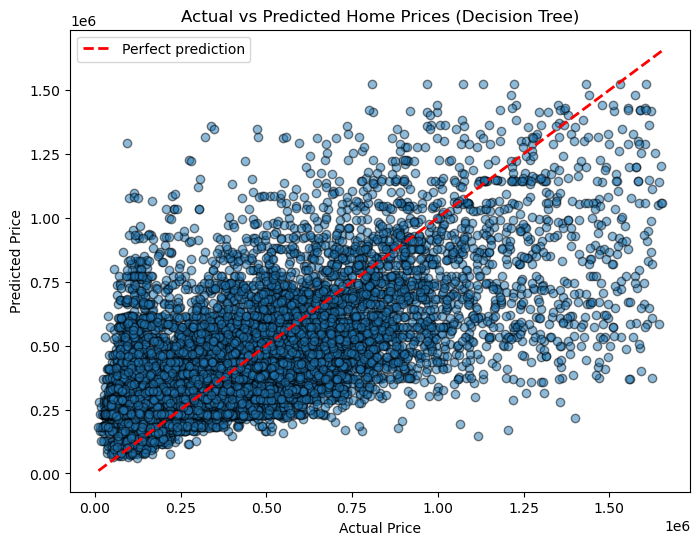

In [23]:
# Scatter plot of Actual vs Predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label="Perfect prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Home Prices (Decision Tree)")
plt.legend()
plt.show()

In [24]:
# Error by price segment
price_bins = pd.qcut(y_test, q=4, labels=["Low", "Medium", "High", "Luxury"])
mae_by_segment = pd.Series(np.abs(y_test - y_pred)).groupby(price_bins).mean()

print("Mean Absolute Error by price segment:")
print(mae_by_segment)

Mean Absolute Error by price segment:
taxvaluedollarcnt
Low       191850.073022
Medium     88596.458982
High      120484.959302
Luxury    249875.878798
Name: taxvaluedollarcnt, dtype: float64


C:\Users\qmw95\AppData\Local\Temp\ipykernel_20580\811463068.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_segment = pd.Series(np.abs(y_test - y_pred)).groupby(price_bins).mean()


<div style="border-radius: 10px; border: purple solid; padding: 10px; font-size: 100%;">

#### Model Selection

The Decision Tree Regressor was selected as the final model. It produced the lowest Mean Absolute Error (MAE) during cross-validation, indicating the most accurate predictions compared to Ridge and Lasso. While Ridge and Lasso are simpler and easier to interpret, they could not capture the complex patterns in the data as effectively as the Decision Tree. Although Decision Trees are generally harder to interpret, their overall performance made them the preferred choice.

To prevent overfitting, limits such as `max_depth` and `min_samples_leaf` were applied to control model complexity.

#### Revisiting an Early Decision

A **log transformation** was applied to features like `calculatedfinishedsquarefeet` and `lotsizesquarefeet` due to their highly skewed values. Some homes were significantly larger than others, which could distort model performance.

This transformation reduced the impact of extreme values, normalized the data distribution, and helped the model learn more effectively. Testing confirmed that the transformation improved stability and accuracy, particularly for features with large ranges, making the model less sensitive to outliers.

#### Findings

Key takeaways from the modeling process include:

* Model choice has a significant impact. The Decision Tree outperformed linear models despite similar data and tuning.
* Feature selection is critical. Linear models benefit from careful feature selection, while tree-based models can leverage more complex data structures.
* Hyperparameter tuning affects performance. Fine-tuning `max_depth`, `min_samples_leaf`, and other parameters substantially improved accuracy.
* Creating derived features (e.g., bathrooms per bedroom or square footage × number of bathrooms) enhanced model understanding of the data.


</div>
